In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install phik -q

import phik
from phik.report import plot_correlation_matrix
from phik import report

import sklearn
from sklearn.model_selection import train_test_split

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]


In [52]:
# Transform names using the next line:
#   ```
#   data.columns = data.columns.str.replace(' ', '_').str.lower()
#   ```
# * Fill in the missing values of the selected features with 0.
# * Rename `MSRP` variable to `price`.

df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={'msrp': 'price'})
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [53]:
### Question 1

# AUTOMATIC

df['transmission_type'].value_counts()

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64

interval columns not set, guessing: ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'price']


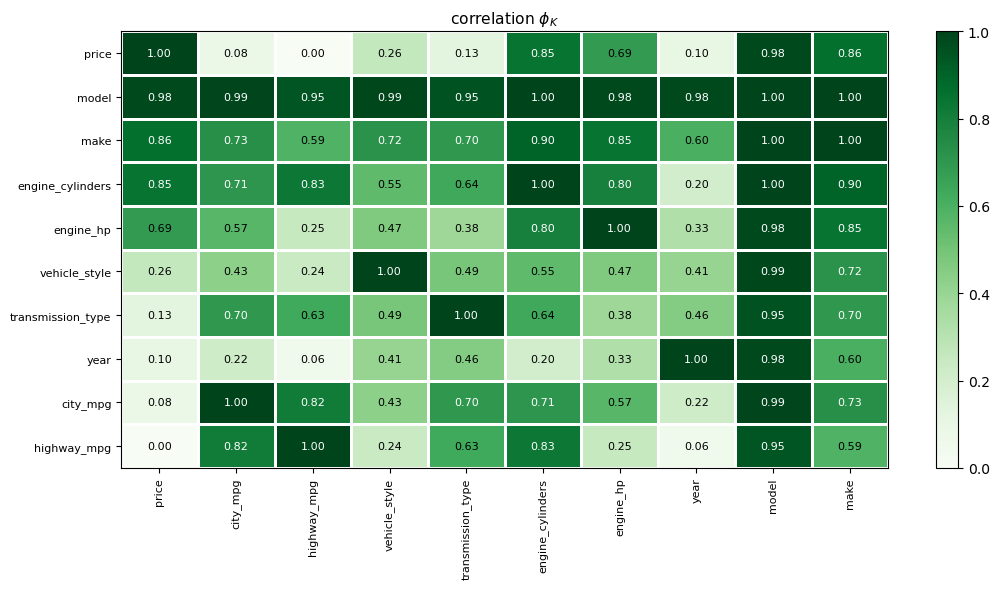

In [54]:
### Question 2

phik_overview = df.phik_matrix().round(4).sort_values('price')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6), )
plt.tight_layout()



In [55]:
print('Engine_hp and year = ', phik_overview.loc['engine_hp', 'year'])
print('Engine_hp and engine_cylinders = ', phik_overview.loc['engine_hp', 'engine_cylinders'])
print('Highway_mpg and engine_cylinders = ', phik_overview.loc['highway_mpg', 'engine_cylinders'])
print('Highway_mpg and city_mpg = ', phik_overview.loc['highway_mpg', 'city_mpg'])

# Highway_mpg and engine_cylinders

Engine_hp and year =  0.328
Engine_hp and engine_cylinders =  0.7968
Highway_mpg and engine_cylinders =  0.826
Highway_mpg and city_mpg =  0.8153


In [56]:
# Make `price` binary

df['above_average'] = (df['price'] > df['price'].mean()).astype(int)

In [61]:
### Split the data

# * Split your data in train/val/test sets with 60%/20%/20% distribution.
# * Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
# * Make sure that the target value (`above_average`) is not in your dataframe.

X = df.drop(columns=['price', 'above_average'])
Y = df['above_average']

X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_test_, X_val_, Y_test_, Y_val_ = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [63]:
### Question 3

# - `transmission_type`


from sklearn.metrics import mutual_info_score

for column in X_train_full.select_dtypes(include=['object']):
  print(column, round(mutual_info_score(X_train_full[column], Y_train_full), 2))

make 0.24
model 0.46
transmission_type 0.02
vehicle_style 0.08


In [64]:
### Question 4

# What accuracy did you get? 
# 
# 0.94

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = X_train_full.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val_.to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=10, 
                           max_iter=1000, random_state=42)

model.fit(X_train, Y_train_full)

Y_pred = model.predict_proba(X_val)[:, 1]
above_average = (Y_pred >= 0.5)

accuracy = (Y_val_ == above_average).mean()
print(round(accuracy, 3))

0.937


In [67]:
### Question 5 

# Which of following feature has the smallest difference?

# - `city_mpg`

# Full model
model_full = LogisticRegression(solver='liblinear', C=10,
                                max_iter=1000, random_state=42)

model_full.fit(X_train, Y_train_full)

Y_pred_full = model_full.predict_proba(X_val)[:, 1]
above_average_full = (Y_pred_full >= 0.5)

accuracy_full = (Y_val_ == above_average_full).mean()
print('Full', round(accuracy_full, 3))

# Exclude each feature
for column in X_train_full.columns:
    X_train = X_train_full.drop(columns=[column])
    X_val = X_val_.drop(columns=[column])
    
    train_dict = X_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = X_val_.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=10,
                                 max_iter=1000, random_state=42)
    
    model.fit(X_train, Y_train_full)
    
    Y_pred = model.predict_proba(X_val)[:, 1]
    above_average = (Y_pred >= 0.5)
    
    accuracy = (Y_val_ == above_average).mean()
    print(column, round(accuracy, 3))
    print(f'Diff with {column}', abs(round(accuracy_full - accuracy, 3)))

Full 0.947
make 0.939
Diff with make 0.008
model 0.918
Diff with model 0.029
year 0.951
Diff with year 0.005
engine_hp 0.93
Diff with engine_hp 0.016
engine_cylinders 0.946
Diff with engine_cylinders 0.0
transmission_type 0.935
Diff with transmission_type 0.012
vehicle_style 0.918
Diff with vehicle_style 0.029
highway_mpg 0.944
Diff with highway_mpg 0.003
city_mpg 0.947
Diff with city_mpg 0.0


In [68]:
### Question 6

from sklearn.linear_model import Ridge

df['log_price'] = np.log1p(df['price'])

X = df.drop(columns=['price', 'above_average', 'log_price'])
Y = df['log_price']

X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_test_, X_val_, Y_test_, Y_val_ = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

X_train_full = X_train_full.reset_index(drop=True)
X_test_ = X_test_.reset_index(drop=True)
X_val_ = X_val_.reset_index(drop=True)

Y_train_full = Y_train_full.reset_index(drop=True)
Y_test_ = Y_test_.reset_index(drop=True)
Y_val_ = Y_val_.reset_index(drop=True)

# one-hot encoding
dv = DictVectorizer(sparse=False)

train_dict = X_train_full.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val_.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Ridge regression
alphas = [0, 0.01, 0.1, 1, 10]
for alpha in alphas:
    model = Ridge(alpha=alpha, solver='sag', random_state=42)
    model.fit(X_train, Y_train_full)
    
    Y_pred = model.predict(X_val)
    rmse = np.sqrt(((Y_val_ - Y_pred) ** 2).mean())
    print(alpha, round(rmse, 3))

0 0.491
0.01 0.491
0.1 0.491
1 0.491
10 0.491
